# Numerai

In [7]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()

# Print all files available for download in the latest v4.1 dataset
[f for f in napi.list_datasets() if f.startswith("v4.1")]

['v4.1/features.json',
 'v4.1/live.parquet',
 'v4.1/live_example_preds.csv',
 'v4.1/live_example_preds.parquet',
 'v4.1/live_int8.parquet',
 'v4.1/meta_model.parquet',
 'v4.1/train.parquet',
 'v4.1/train_int8.parquet',
 'v4.1/validation.parquet',
 'v4.1/validation_example_preds.csv',
 'v4.1/validation_example_preds.parquet',
 'v4.1/validation_int8.parquet']

In [8]:
import pandas as pd
import json

# Download the training data and feature metadata
# This may take a few minutes 🍵
napi.download_dataset("v4.1/train.parquet");
napi.download_dataset("v4.1/features.json");

# Load the training data but only the "small" subset of features to save time and memory
# In practice you will want to use all the features to maximize your model's performance
feature_metadata = json.load(open("v4.1/features.json")) 
feature_cols = feature_metadata["feature_sets"]["small"]
training_data = pd.read_parquet("v4.1/train.parquet", columns= ["era"] + feature_cols + ["target"]) 

# Print the training data
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 5)
training_data

2023-09-04 17:49:37,798 INFO numerapi.utils: starting download
v4.1/train.parquet: 1.45GB [04:50, 5.00MB/s]                               
2023-09-04 17:54:30,450 INFO numerapi.utils: starting download
v4.1/features.json: 703kB [00:05, 138kB/s]                             


,era,feature_bijou_penetrant_syringa,...,feature_unventilated_sollar_bason,target
id,,,,,
n003bba8a98662e4,0001,0.00,...,0.00,0.25
n003bee128c2fcfc,0001,0.50,...,0.25,0.75
n0048ac83aff7194,0001,0.25,...,1.00,0.25
n00691bec80d3e02,0001,0.75,...,0.75,0.75
n00b8720a2fdc4f2,0001,0.00,...,0.00,0.50
...,...,...,...,...,...
nffcc1dbdf2212e6,0574,1.00,...,1.00,0.75
nffd71b7f6a128df,0574,0.75,...,0.50,0.25
nffde3b371d67394,0574,0.75,...,1.00,0.25


2023-09-04 17:55:00,160 INFO matplotlib.font_manager: Failed to extract font properties from /usr/share/fonts/adobe-source-code-pro/SourceCodeVF-Upright.otf: In FT2Font: Can not load face (SFNT font table missing; error code 0x8e)
2023-09-04 17:55:00,258 INFO matplotlib.font_manager: Failed to extract font properties from /usr/share/fonts/adobe-source-sans/SourceSansVariable-Roman.otf: In FT2Font: Can not load face (SFNT font table missing; error code 0x8e)
2023-09-04 17:55:00,286 INFO matplotlib.font_manager: Failed to extract font properties from /usr/share/fonts/adobe-source-code-pro/SourceCodeVF-Italic.otf: In FT2Font: Can not load face (SFNT font table missing; error code 0x8e)
2023-09-04 17:55:00,408 INFO matplotlib.font_manager: Failed to extract font properties from /usr/share/fonts/adobe-source-sans/SourceSans3VF-Upright.otf: In FT2Font: Can not load face (SFNT font table missing; error code 0x8e)
2023-09-04 17:55:00,441 INFO matplotlib.font_manager: Failed to extract font pro

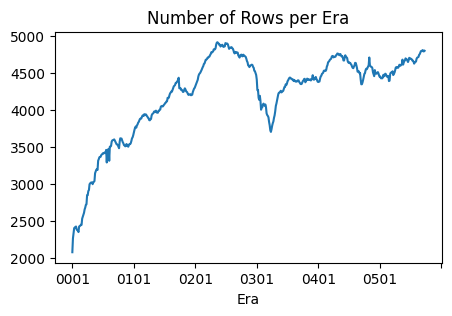

In [9]:
training_data.groupby("era").size().plot(title="Number of Rows per Era", figsize=(5, 3), xlabel="Era");

# Modeling
o objetivo aqui é criar um modelo para submeter no numer.ai



## LightGBM
isto faz trees

primeiro vou criar um modelo com as opcoes default dadas pelo numerai para ver como se sai


In [ ]:
import lightgbm as lgb

try:
    # load aos modelos de treino se ja existir
    model = lgb.Booster(model_file='small_lgb_tree.model');
except lgb.basic.LightGBMError:
    # se naoe xistir criar o modelo e gravar
    model = lgb.LGBMRegressor(
        n_estimators = 2000,
        learning_rate = 0.01,
        max_depth = 5,
        num_leaves = 2**5,
        colsample_bytree = 0.1
    )

    #treinar o modelo
    model.fit(
        training_data[feature_cols],
        training_data["target"]
    )

    # gravar o modelo
    model.booster_.save_model("small_lbg_tree.model")

testar o modelo agora



In [ ]:
# dl do dataset de validation
napi.download_dataset("v4.1/validation.parquet")
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + feature_cols + ["target"]) 

# load do dataset de treino
validation_data = validation_data[validation_data["data_type"] == "validation" ]
del validation_data["data_type"]

# gerar as previsoes
validation_data["prediction"] = model.predict(validation_data[feature_cols])
validation_data[["era", "prediction", "target"]]


Definir a funcao de scoring para corr
esta é a maneira principal de scoring do numerai

In [10]:
from scipy import stats
import numpy as np

# Numerai's primary scoring metric
def numerai_corr(preds, target):
    # rank (keeping ties) then gaussianize predictions to standardize prediction distributions
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0
    centered_target = target - target.mean()
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

In [ ]:
# correlacao /era das previsoes com o metamodelo + um plot

per_era_corr = validation_data.groupby("era").apply(lambda x: numerai_corr(x["prediction"], x["target"]))
per_era_corr.plot(kind="bar", title="Validation Correlation", figsize=(10, 6), xticks=[]);

In [ ]:
# Plot da corr/cummulatia / era, mais util porque permite ter nocao de "quanto ganha"__qualname__ 
per_era_corr.cumsum().plot(kind="line", title="Cumulative Validation Correlation", figsize=(10, 6));

## XGBoost
mesma coisa mas com xgboost


In [ ]:
import numpy as np
import xgboost as xgb


# Initialize the XGBoost regression model tree
model = xgb.XGBRegressor(
    n_estimators = 2000,
    learning_rate = 0.01,
    max_depth = 5,
    num_leaves = 2**5,
    colsample_bytree = 0.1,
    random_state=420,
    tree_method='gpu_hist',
    gpu_id= 0
    
    )

# Train the model on the training data
model.fit(
    training_data[feature_cols],
    training_data["target"]
    )

# dl do dataset de validation
napi.download_dataset("v4.1/validation.parquet")
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + feature_cols + ["target"]) 

# load do dataset de treino
validation_data = validation_data[validation_data["data_type"] == "validation" ]
del validation_data["data_type"]

# gerar as previsoes
validation_data["prediction"] = model.predict(validation_data[feature_cols])
validation_data[["era", "prediction", "target"]]

# gravar o modelo
model.booster_.save_model("small_lbg_tree.model")

In [ ]:

# correlacao /era das previsoes com o metamodelo + um plot

per_era_corr = validation_data.groupby("era").apply(lambda x: numerai_corr(x["prediction"], x["target"]))
per_era_corr.plot(kind="bar", title="Validation Correlation", figsize=(10, 6), xticks=[]);

In [ ]:
# Plot da corr/cummulatia / era, mais util porque permite ter nocao de "quanto ganha"__qualname__ 
per_era_corr.cumsum().plot(kind="line", title="Cumulative Validation Correlation", figsize=(10, 6));